In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
from matplotlib.offsetbox import AnchoredText
from statannotations.Annotator import Annotator

In [5]:
###TMB###n=306
count_mx_306=pd.read_csv("/Users/chenyingyi/Desktop/TVGH_HNSCC/count_mx/TVGH_306_count_mx.csv",sep=',',index_col=0)
count_mx_306=count_mx_306.T
count_mx_306.index = count_mx_306.index.str.rstrip('T')
count_mx_306.shape

(306, 14782)

In [6]:
def get_TMB(df):
    total_count = df.sum(axis=1)
    capture_size = 42988611/1e6
    tmb = total_count / capture_size
    df['TMB']=tmb
    return df

In [7]:
TMB_df=get_TMB(count_mx_306)
TMB_df

,TP53,TTN,FAT1,MUC19,NOTCH1,MUC16,OBSCN,FLG,MUC17,HRNR,...,ZSCAN22,ZSCAN23,ZSCAN4,ZSCAN9,ZSWIM6,ZXDA,ZXDB,ZYG11B,ZYX,TMB
H0031,2,10,7,14,1,3,11,0,12,1,...,0,0,0,0,0,0,0,0,0,74.926822
H0251,2,23,1,2,0,6,3,1,3,5,...,0,0,0,0,0,0,0,0,0,85.511021
H0252,2,14,3,5,0,1,7,2,27,9,...,0,0,0,0,0,0,0,0,0,79.346597
H0020,1,1,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,3.675392
H0276,1,1,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.651865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H0162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.465504
H0379,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.395719
H0358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.162834
H0115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.069786


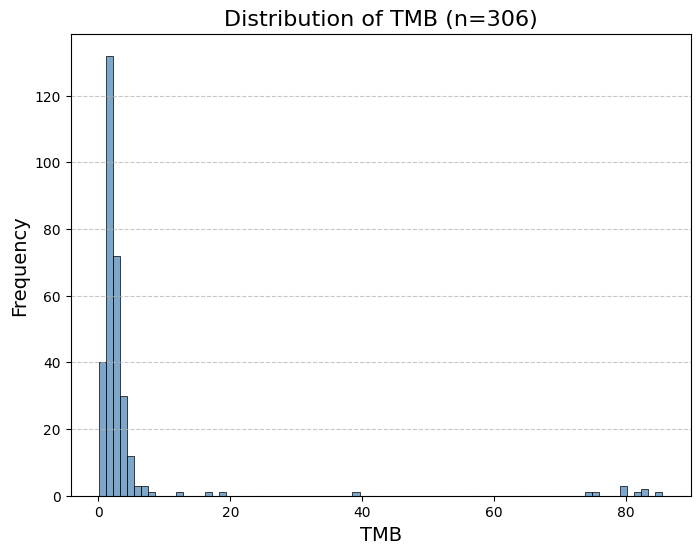

In [8]:
# Plot the distribution of TMB # All patients
plt.figure(figsize=(8, 6))
sns.histplot(count_mx_306['TMB'],bins=80, color='steelblue', alpha=0.7)
plt.title("Distribution of TMB (n=306)", fontsize=16)
plt.xlabel("TMB", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Surgical v.s. non-surgical

In [13]:
non_surgical_cnv = pd.read_csv("/Users/chenyingyi/Desktop/TVGH_HNSCC/non_surgical_cnv.csv", index_col=0)
surgical_cnv = pd.read_csv("/Users/chenyingyi/Desktop/TVGH_HNSCC/surgical_cnv.csv", index_col=0)
CCRT_clinical = pd.read_excel("/Users/chenyingyi/Desktop/TVGH_HNSCC/CCRT_120_clinical.xlsx", index_col=0)
recur_id = CCRT_clinical[(CCRT_clinical['local_recur'] == 1) | (CCRT_clinical['distant_mets'] == 1)].index
no_recur_id = CCRT_clinical[(CCRT_clinical['local_recur'] == 0) & (CCRT_clinical['distant_mets'] == 0)].index

non_surgical_tmb = TMB_df.loc[TMB_df.index.isin(non_surgical_cnv.index)].copy()
non_surgical_tmb['group'] = pd.NA
non_surgical_tmb.loc[non_surgical_tmb.index.isin(recur_id), 'group'] = 'Recurrence'
non_surgical_tmb.loc[non_surgical_tmb.index.isin(no_recur_id), 'group'] = 'No recurrence'
non_surgical_tmb['group'] = non_surgical_tmb['group'].astype(str)

surgical_tmb = TMB_df.loc[TMB_df.index.isin(surgical_cnv.index)].copy()
surgical_tmb['group'] = pd.NA
surgical_tmb.loc[surgical_tmb.index.isin(recur_id), 'group'] = 'Recurrence'
surgical_tmb.loc[surgical_tmb.index.isin(no_recur_id), 'group'] = 'No recurrence'
surgical_tmb['group'] = surgical_tmb['group'].astype(str)


In [14]:
###If drop the high-TMB samples is needed
#non_surgical_tmb=non_surgical_tmb.drop(index=['H0252'])
#surgical_tmb=surgical_tmb.drop(index=['H0205','H0251','H0262','H0189'])

In [17]:
###np.where(condition[, x, y]) x=True, y=False
###surgical在左[0], non_surgical在右[1]
def plot_two_group(df0, df1, column):
    order = ["Recurrence", "No recurrence"]

    fig, axes = plt.subplots(1, 2, figsize=(7, 4), sharey=True)

    #surgical (n=90)
    color_palette = {"Recurrence": "steelblue", "No recurrence": "lightsteelblue"} #blue for surgical
    pairs = [("Recurrence", "No recurrence")]
    ax = sns.boxplot(x="group",y=column,data=df0,palette=color_palette,hue="group",ax=axes[0],order=order,legend=False)
    annotator = Annotator(ax, pairs, data=df0, x="group", y=column, order=order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside',fontsize=12)
    annotator.apply_and_annotate()
    axes[0].set_title(f"{column} in surgical group",fontsize=16) 
    axes[0].set_xlabel("",fontsize=16)
    axes[0].tick_params(axis='x', labelsize=12) #Recurrence / No recurrence
    #axes[0].set_ylabel(column,fontsize=14) #TMB
    axes[0].set_ylabel('MSI (%)',fontsize=14) #MSI
    axes[0].grid(axis="y", linestyle="--", alpha=0.7)

    #non-surgical (n=30)
    color_palette = {"Recurrence": "tomato", "No recurrence": "mistyrose"} #blue for surgical
    ax = sns.boxplot(x="group",y=column,data=df1,palette=color_palette,hue="group",ax=axes[1],order=order,legend=False)
    annotator = Annotator(ax, pairs, data=df1, x="group", y=column, order=order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside',fontsize=12)
    annotator.apply_and_annotate()
    axes[1].set_title(f"{column} in non-surgical group",fontsize=16) 
    axes[1].set_xlabel("",fontsize=16)
    axes[1].tick_params(axis='x', labelsize=12) #Recurrence / No recurrence
    #axes[1].set_ylabel(column,fontsize=14) #TMB
    axes[1].set_ylabel('MSI (%)',fontsize=14) #MSI
    axes[1].grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Recurrence vs. No recurrence: Mann-Whitney-Wilcoxon test two-sided, P_val:6.530e-01 U_stat=8.830e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Recurrence vs. No recurrence: Mann-Whitney-Wilcoxon test two-sided, P_val:6.602e-01 U_stat=9.950e+01


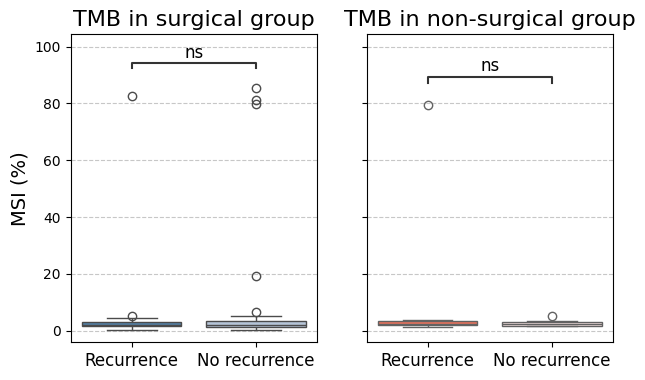

In [18]:
plot_two_group(surgical_tmb, non_surgical_tmb, "TMB")

MSI

In [19]:
msi_2=pd.read_csv("/Users/chenyingyi/Desktop/TVGH_HNSCC/MSI/msi_scores_2.csv",index_col=0)
msi_2.rename(columns={'MSI_Score(%)': 'MSI'}, inplace=True)

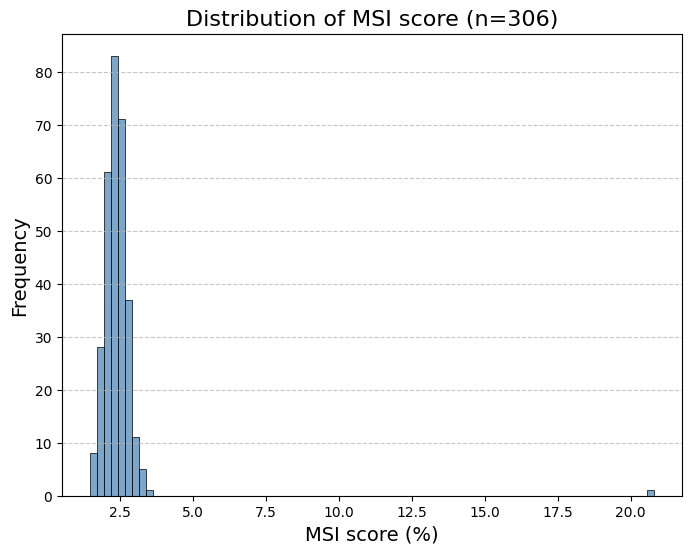

In [20]:
# Plot the distribution of MSI
plt.figure(figsize=(8, 6))
sns.histplot(msi_2['MSI'],bins=80, color='steelblue', alpha=0.7)

plt.title("Distribution of MSI score (n=306)", fontsize=16)
plt.xlabel("MSI score (%)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [21]:
non_surgical_msi = msi_2.loc[msi_2.index.isin(non_surgical_cnv.index)].copy()
non_surgical_msi['group'] = pd.NA
non_surgical_msi.loc[non_surgical_msi.index.isin(recur_id), 'group'] = 'Recurrence'
non_surgical_msi.loc[non_surgical_msi.index.isin(no_recur_id), 'group'] = 'No recurrence'
non_surgical_msi['group'] = non_surgical_msi['group'].astype(str)

surgical_msi = msi_2.loc[msi_2.index.isin(surgical_cnv.index)].copy()
surgical_msi['group'] = pd.NA
surgical_msi.loc[surgical_msi.index.isin(recur_id), 'group'] = 'Recurrence'
surgical_msi.loc[surgical_msi.index.isin(no_recur_id), 'group'] = 'No recurrence'
surgical_msi['group'] = surgical_msi['group'].astype(str)

In [22]:
surgical_msi

,MSI,group
Sample,,
H0288,2.60,No recurrence
H0322,2.38,No recurrence
H0309,1.46,No recurrence
H0307,2.08,Recurrence
H0290,1.97,Recurrence
...,...,...
H0281,1.95,No recurrence
H0230,2.05,No recurrence
H0181,2.57,Recurrence


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Recurrence vs. No recurrence: Mann-Whitney-Wilcoxon test two-sided, P_val:7.519e-01 U_stat=8.680e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Recurrence vs. No recurrence: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.105e+02


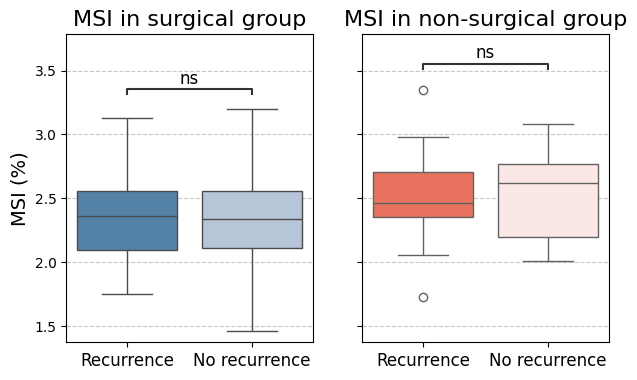

In [23]:
plot_two_group(surgical_msi, non_surgical_msi, "MSI")

Different site

In [24]:
Clinical = pd.read_excel("/Users/chenyingyi/Desktop/TVGH_HNSCC/clinical data/Clinical Data v.1.06.xlsx", index_col=1)
tmb_map=TMB_df.loc[TMB_df.index.isin(Clinical.index)].copy()
Clinical=Clinical[Clinical.index.isin(tmb_map.index)]
print("samples with TMB",tmb_map.shape)
print("clinical",Clinical.shape)
### Add site to tmb df
site=Clinical[['Site']]
tmb_map = tmb_map.join(site, how='left')
site_labels = {1: 'OCC', 2: 'OPC', 3: 'HPC', 4: 'LC'}
tmb_map['Site'] = tmb_map['Site'].astype(int).map(site_labels)
tmb_map

samples with TMB (284, 14783)
clinical (284, 71)


,TP53,TTN,FAT1,MUC19,NOTCH1,MUC16,OBSCN,FLG,MUC17,HRNR,...,ZSCAN23,ZSCAN4,ZSCAN9,ZSWIM6,ZXDA,ZXDB,ZYG11B,ZYX,TMB,Site
H0031,2,10,7,14,1,3,11,0,12,1,...,0,0,0,0,0,0,0,0,74.926822,OCC
H0251,2,23,1,2,0,6,3,1,3,5,...,0,0,0,0,0,0,0,0,85.511021,OCC
H0252,2,14,3,5,0,1,7,2,27,9,...,0,0,0,0,0,0,0,0,79.346597,OCC
H0020,1,1,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,3.675392,OCC
H0276,1,1,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2.651865,OCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H0177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.488766,OPC
H0162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.465504,OPC
H0358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.162834,OCC
H0115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.069786,OCC


In [25]:
###If drop the high-TMB samples is needed
#tmb_map=tmb_map.drop(index=['H0355','H0205','H0251','H0262','H0189','H0252','H0096','H0031','H0095'])

In [26]:
def plot_anatomic_site(df, column): #TMB or MSI
    order = ['OCC', 'OPC', 'HPC', 'LC']

    plt.figure(figsize=(8, 6))
    color_palette = {"OCC": "lightpink", "OPC": "royalblue", "HPC": "turquoise", "LC": "limegreen"}
    ax = sns.boxplot(data=df, x="Site", y=column, order=order, palette=color_palette,hue="Site",legend=False)
    pairs = [("LC", "HPC"), ("HPC", "OCC"), ("OCC", "OPC"), ("HPC", "OPC"), ("LC", "OCC"), ("LC", "OPC")]
    annotator = Annotator(ax, pairs, data=df, x="Site", y=column, order=order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
    annotator.apply_and_annotate()
    plt.xlabel("Anatomic site",fontsize=14)
    plt.ylabel(column,fontsize=14)
    plt.title(f"{column} distribution by anatomic site",fontsize=16)
    plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HPC vs. LC: Mann-Whitney-Wilcoxon test two-sided, P_val:5.321e-02 U_stat=3.640e+02
OCC vs. OPC: Mann-Whitney-Wilcoxon test two-sided, P_val:6.939e-01 U_stat=3.999e+03
OPC vs. HPC: Mann-Whitney-Wilcoxon test two-sided, P_val:4.633e-02 U_stat=5.855e+02
OCC vs. HPC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.207e-02 U_stat=2.503e+03
OPC vs. LC: Mann-Whitney-Wilcoxon test two-sided, P_val:9.514e-01 U_stat=3.340e+02
OCC vs. LC: Mann-Whitney-Wilcoxon test two-sided, P_val:9.438e-01 U_stat=1.434e+03


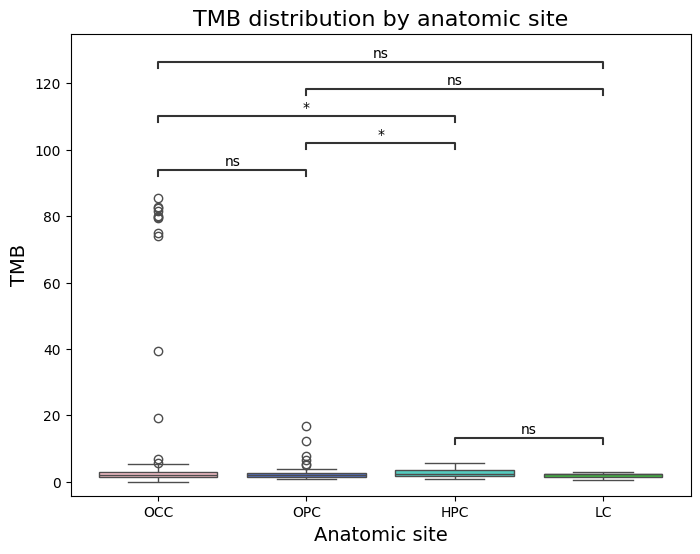

In [27]:
plot_anatomic_site(tmb_map, "TMB")#TMB or MSI

In [28]:
msi_map=msi_2.loc[msi_2.index.isin(Clinical.index)].copy()
Clinical=Clinical[Clinical.index.isin(msi_map.index)]
print("samples with MSI",msi_map.shape)
print("clinical",Clinical.shape)
### Add site to tmb df
site=Clinical[['Site']]
msi_map = msi_map.join(site, how='left')
site_labels = {1: 'OCC', 2: 'OPC', 3: 'HPC', 4: 'LC'}
msi_map['Site'] = msi_map['Site'].astype(int).map(site_labels)
msi_map

samples with MSI (284, 1)
clinical (284, 71)


,MSI,Site
Sample,,
H0323,2.42,OCC
H0266,2.49,OCC
H0294,2.43,OPC
H0278,2.34,OCC
H0301,2.18,OPC
...,...,...
H0264,2.55,OCC
H0027,2.48,OCC
H0043,1.98,OCC


In [29]:
msi_map.columns

Index(['MSI', 'Site'], dtype='object')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HPC vs. LC: Mann-Whitney-Wilcoxon test two-sided, P_val:2.304e-01 U_stat=3.285e+02
OCC vs. OPC: Mann-Whitney-Wilcoxon test two-sided, P_val:8.182e-04 U_stat=2.810e+03
OPC vs. HPC: Mann-Whitney-Wilcoxon test two-sided, P_val:3.531e-01 U_stat=8.885e+02
OCC vs. HPC: Mann-Whitney-Wilcoxon test two-sided, P_val:3.896e-02 U_stat=2.662e+03
OPC vs. LC: Mann-Whitney-Wilcoxon test two-sided, P_val:7.019e-02 U_stat=4.345e+02
OCC vs. LC: Mann-Whitney-Wilcoxon test two-sided, P_val:9.891e-01 U_stat=1.421e+03


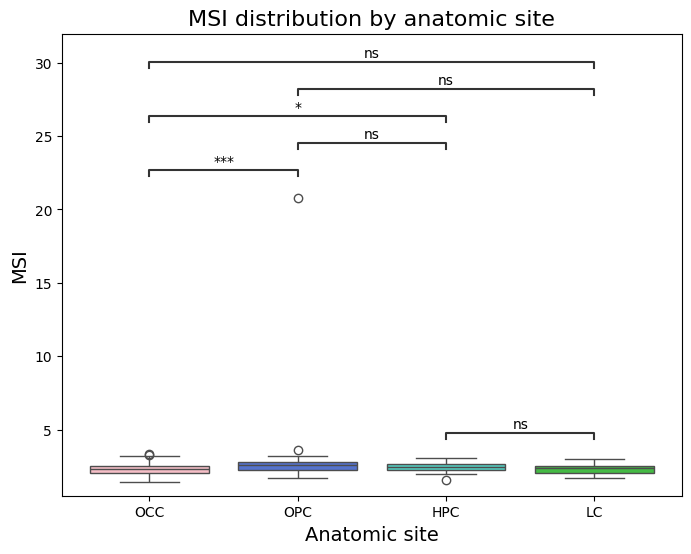

In [30]:
plot_anatomic_site(msi_map, "MSI")